# **Time to Earthquake Prediction Kernel**

## This kernel describes a holistic procedure to solve the given problem. We will start by exploring the data, followed by feature extraction, and finally, use an appropriate model to make predictions after training and validation.

### Sequence of Steps:
1. Load the training data from the given dataset.
2. Visualise the training data - Input Acoustic Signal and Time_To_Failure
3. Extract Features using appropriate mathematical functions
4. Train and Validate using an appropriate model
5. Make Predictions
6. Save results


This kernel is inspired from Lavanya's kernel that can be found [here](https://www.kaggle.com/lavanyadml/lanl-earthquake-prediction)

## ** Step 1: Loading the Training Data and Dataframe setup**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

from tqdm import tqdm, tqdm_notebook
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
train_data = pd.read_csv('../input/train.csv',dtype={'acoustic_data': np.int16, 'time_to_failure':np.float64})

In [3]:
pd.options.display.precision = 10
train_data.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [4]:
print("Dimensions of the training data, Rows: {}, Columns:{}".format(train_data.shape[0],train_data.shape[1]))

Dimensions of the training data, Rows: 629145480, Columns:2


## **Step 2: Data Visualisation**

### Since the dataset is massive, we plot only 1 in every 100 points that is given to us, or in other words 1% of the given data

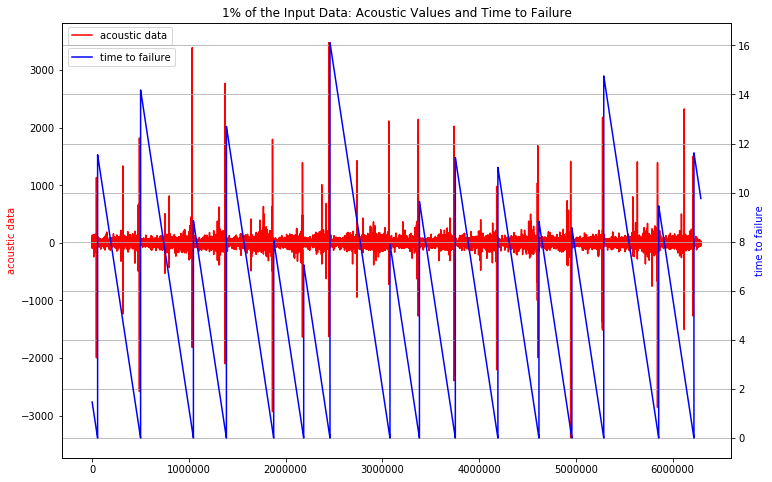

In [5]:
acoustic_values = train_data['acoustic_data'].values[::100]
time_to_failure_values = train_data['time_to_failure'].values[::100]

fig, ax1 = plt.subplots(figsize=(12, 8))
plt.title("1% of the Input Data: Acoustic Values and Time to Failure")
plt.plot(acoustic_values, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(time_to_failure_values, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)

## **Important Note**

### The data is recorded in segments at a frequency of 4MHz, each segment lasting for 0.0375 seconds, thus constituting 150,000 data points.

### So, we will now plot the first 6,000,000 points in the dataset, or in other words, the first 40 segments.

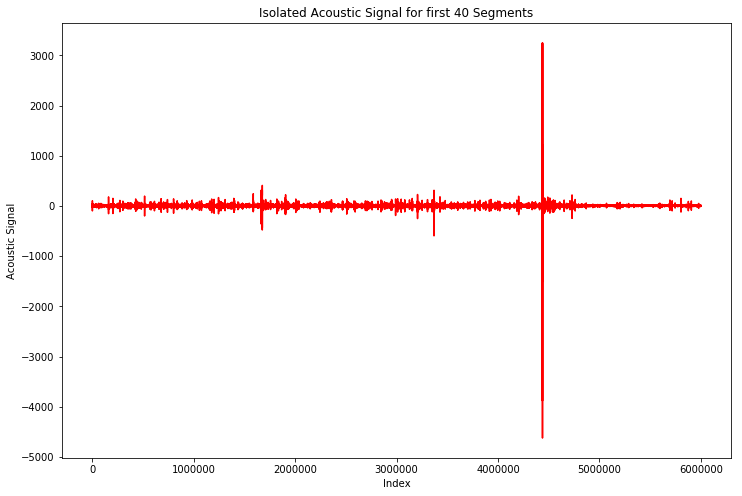

In [6]:
acoustic_values = train_data['acoustic_data'].values[0:6000000]
plt.figure(2,figsize=(12,8))
plt.title("Isolated Acoustic Signal for first 40 Segments")
plt.xlabel("Index")
plt.ylabel("Acoustic Signal")
plt.plot(acoustic_values, color='r')

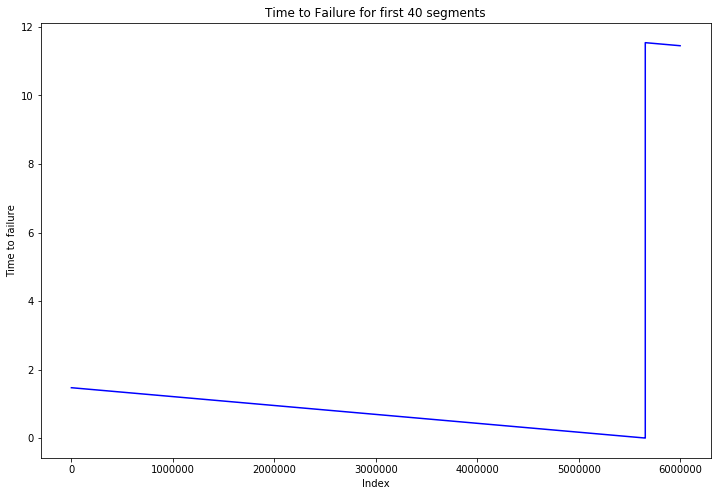

In [7]:
time_to_failure_values = train_data['time_to_failure'].values[0:6000000]
plt.figure(3,figsize=(12,8))
plt.title("Time to Failure for first 40 segments")
plt.xlabel("Index")
plt.ylabel("Time to failure")
plt.plot(time_to_failure_values,color='b')

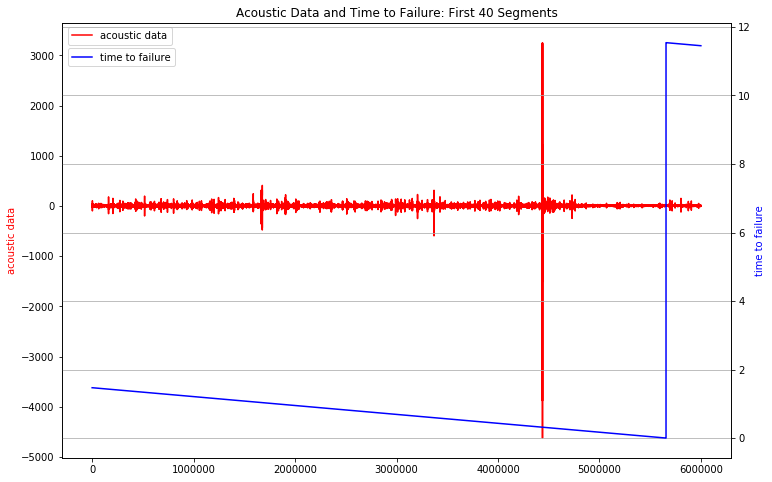

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.title("Acoustic Data and Time to Failure: First 40 Segments")
plt.plot(acoustic_values, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(time_to_failure_values, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)

## **Summary**

### We see that the acoustic signal shows a massive spike, followed by a quieter than usual period in the build up to an Earthquake, when Time_to_Failure hits 0

## **Step 3: Feature Extraction**

### The entire data is first split into segments of 150,000 data points each, giving us 4194 segments to train on.

### In this step, the data to be trained on is created by extracting features. To capture the inherent frequency-magnitude characteristics of the wave, we use the **Fast Fourier Transform (FFT)** on each segment and take the real and imaginary components and calculate the mean, standard deviation, maximum and minimum for each.

### In addition, we take several other features such as the quartiles, Median Absolute Deviation (MAD), in addition to basic statistical features of standard deviation, mean, max and min. Some other functions such as kurtosis and skew are also used.

In [9]:
segment_size = 150000
num_segments = int(np.floor(train_data.shape[0]/segment_size))

X_train = pd.DataFrame(index=range(num_segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(num_segments), dtype=np.float64, columns=['time_to_failure'])

In [10]:
def create_features(seg_id, seg, X):
    x = pd.Series(seg['acoustic_data'].values)
    z = np.fft.fft(x)
    
    realFFT = np.real(z)
    imagFFT = np.imag(z)
    
    X.loc[seg_id, 'mean'] = x.mean()
    X.loc[seg_id, 'std'] = x.std()
    X.loc[seg_id, 'max'] = x.max()
    X.loc[seg_id, 'min'] = x.min()
    X.loc[seg_id, 'mad'] = x.mad()
    X.loc[seg_id, 'kurt'] = x.kurtosis()
    X.loc[seg_id, 'skew'] = x.skew()
    
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    
    X.loc[seg_id, 'q95'] = np.quantile(x, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(x, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(x, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(x, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)

## ** Step 4: Training and Validation ** 

### We start off by creating the training data, and targets.

### This is followed by scaling the training data, and the same is then done for the testing data.

In [11]:
for seg_id in tqdm_notebook(range(num_segments)):
    seg = train_data.iloc[seg_id*segment_size:seg_id*segment_size+segment_size]
    create_features(seg_id, seg, X_train)
    y_train.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

### Scaling the training data

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,mean,std,max,min,mad,kurt,skew,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01
0,1.4241404998,-0.1702135829,-0.2181935087,0.1932181852,-0.1355550505,-0.4913099051,-0.3137031809,1.1993162055,-0.1050065934,1.4241404998,0.1567360867,-0.4585696657,-0.1690520053,-0.0854188513,0.0854188513,-0.0983930971,-0.1633661486,0.0789750565,0.2287324620,-0.0217572374,-0.1590558892,0.2566047145,0.0
1,0.8057160326,0.0047340170,0.0639360080,-0.0180372712,0.0562333733,0.4316957049,0.5538912151,0.0788858106,-0.0085985973,0.8057160326,-0.2221179484,0.2867049705,0.0072117521,0.0428594029,-0.0428594029,0.3256967742,0.0475309667,0.0789750565,0.0160612252,-0.0217572374,-0.0329262552,0.2566047145,0.0
2,1.5111552594,0.0492521967,-0.0862887996,0.1630388343,0.2870142011,-0.4928308995,0.1915337154,0.0788858106,0.0437995115,1.5111552594,-0.1042537747,-0.5402435985,0.0548393607,0.1385527700,-0.1385527700,0.7497866455,0.3990261588,-0.3472250169,-0.2675004238,0.4400335196,0.1562681958,0.2566047145,0.0
3,1.4949343751,0.0439496380,0.1225603231,-0.1877961201,0.1011516545,0.6839376531,1.3212453217,0.0788858106,0.0447980435,1.4949343751,-0.0338507884,-0.4177326994,0.0422165383,0.0477208015,-0.0477208015,0.3256967742,0.1178300051,0.0789750565,-0.0548291870,0.2091381411,0.0301385618,0.2566047145,0.0
4,1.5202420790,0.0884950703,-0.0679687011,0.0875904570,0.2115328756,-0.2174338688,-0.1283242372,1.1993162055,0.0786523017,1.5202420790,-0.0563239391,0.1131478634,0.0868416825,0.0518598726,-0.0518598726,0.3256967742,0.3990261588,0.0789750565,-0.2675004238,0.2091381411,0.2193330128,0.2566047145,0.0


In [13]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


In [14]:
submission_files = pd.read_csv('../input/sample_submission.csv',index_col='seg_id')
submission_files

X_test = pd.DataFrame(columns=X_train.columns,index=submission_files.index,dtype=np.float64)

for seg_id in tqdm_notebook(X_test.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, X_test)

X_test.head()

,mean,std,max,min,mad,kurt,skew,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01
seg_id,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.4917800000,4.8936896870,115.0,-75.0,3.2485210541,28.8375680992,0.3279076353,4.0,2198.3440358597,673767.0,-14758.4425585804,-4.8506384095e-16,1336.3706446941,17561.3320205683,-17561.3320205683,11.0,18.0,-2.0,-8.0,11.0,19.0,1.0,0.0
seg_0012b5,4.1711533333,5.9228394432,152.0,-140.0,3.4292084979,56.2189545505,0.2957078592,5.0,2289.9223785971,625673.0,-22626.3877056905,3.6379788071e-16,1621.1037906316,24935.9328612943,-24935.9328612943,11.0,20.0,-2.0,-12.0,12.0,24.0,1.0,0.0
seg_00184e,4.6102600000,6.9469900775,248.0,-193.0,3.4619840107,162.1182836284,0.4286882883,8.0,2611.0556294342,691539.0,-23593.9392935220,6.7908937732e-16,1899.8819700181,25121.8567303736,-25121.8567303736,11.0,20.0,-2.0,-11.0,12.0,25.0,1.0,0.0
seg_003339,4.5314733333,4.1141466030,85.0,-93.0,2.6785027580,41.2418274621,0.0618893629,2.0,2085.5434543543,679721.0,-11908.5379586466,-8.4886172165e-16,1126.7455347149,14075.6750638649,-14075.6750638649,10.0,14.0,-1.0,-5.0,10.0,16.0,1.0,0.0
seg_0042cc,4.1283400000,5.7971636362,177.0,-147.0,3.2838555877,79.5397076131,0.0738983508,5.0,2243.9299231482,619251.0,-24048.0558696796,3.8805107276e-16,1600.7074998262,24201.7689892997,-24201.7689892997,10.0,19.0,-2.0,-10.0,11.0,22.0,1.0,0.0


In [15]:
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index = submission_files.index)
X_test_scaled.head()

,mean,std,max,min,mad,kurt,skew,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01
seg_id,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,1.3602626454,-0.2047898189,-0.1833281333,0.2715217513,-0.1731977370,-0.5840683362,0.4760881635,-0.0155648453,-0.1330101874,1.3602626454,0.3554184520,-0.2472393474,-0.2064132311,-0.3050054141,0.3050054141,0.0004718856,-0.1651494699,0.2865031382,0.2741005359,-0.2221033417,-0.1947867517,0.90746269,0.0
seg_0012b5,0.0893369943,-0.0870781104,-0.0494953152,0.0483997811,-0.0668431649,-0.1814763892,0.4028328178,0.1635674095,-0.0935664903,0.0893369943,0.0854634203,0.2217316454,-0.0874791618,-0.0516133065,0.0516133065,0.0004718856,-0.0291783461,0.2865031382,0.0056345626,0.0065170759,-0.0462076482,0.90746269,0.0
seg_00184e,1.8299031551,0.0300618104,0.2977465911,-0.1335304409,-0.0475511457,1.3755746809,0.7053668253,0.7009641737,0.0447487739,1.8299031551,0.0522660080,0.3959208713,0.0289674963,-0.0452249417,0.0452249417,0.0004718856,-0.0291783461,0.2865031382,0.0727510559,0.0065170759,-0.0164918275,0.90746269,0.0
seg_003339,1.5176022580,-0.2939521081,-0.2918412291,0.2097341288,-0.5087166348,-0.4016869605,-0.1291104701,-0.3738293548,-0.1815945125,1.5176022580,0.4532007918,-0.4482269158,-0.2939744009,-0.4247729760,0.4247729760,-0.4122707243,-0.4370917176,0.7004812409,0.4754500158,-0.4507237594,-0.2839342138,0.90746269,0.0
seg_0042cc,-0.0803699241,-0.1014526111,0.0409322645,0.0243712612,-0.1523994506,0.1614115576,-0.1017897038,0.1635674095,-0.1133758954,-0.0803699241,0.0366849315,0.2351308167,-0.0959987666,-0.0768392591,0.0768392591,-0.4122707243,-0.0971639080,0.2865031382,0.1398675493,-0.2221033417,-0.1056392896,0.90746269,0.0


In [16]:
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000, loss='ls')
num_folds = 8
cross_validate_results = cross_validate(model, X_train_scaled, y_train.values.flatten(), n_jobs=-1, return_estimator= True, return_train_score=True, cv=num_folds, verbose=8, scoring="neg_mean_absolute_error" )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   13.0s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   21.5s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   21.6s finished


In [17]:
cross_validate_results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score', 'train_score'])

In [18]:
for i in range(num_folds):
    print("Fold: {} Training MAE: {}".format(i,-cross_validate_results['train_score'][i]))
    print("Fold: {} Validation MAE: {}".format(i,-cross_validate_results['test_score'][i]))

Fold: 0 Training MAE: 1.039695982280407
Fold: 0 Validation MAE: 2.734040151238369
Fold: 1 Training MAE: 1.119567330362848
Fold: 1 Validation MAE: 1.9248193343457773
Fold: 2 Training MAE: 1.0685629054352013
Fold: 2 Validation MAE: 2.395099867737395
Fold: 3 Training MAE: 0.9672446938725461
Fold: 3 Validation MAE: 3.5278087634771107
Fold: 4 Training MAE: 1.0955708182264625
Fold: 4 Validation MAE: 2.008705478747503
Fold: 5 Training MAE: 1.1361210141340656
Fold: 5 Validation MAE: 1.4882639375558702
Fold: 6 Training MAE: 1.051469270173247
Fold: 6 Validation MAE: 2.605314784365524
Fold: 7 Training MAE: 1.0714698048903757
Fold: 7 Validation MAE: 2.434743111574792


In [19]:
cross_validate_results['estimator']

(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0

In [20]:
new_model = cross_validate_results['estimator'][1]
y_predictions = new_model.predict(X_train_scaled)
mean_absolute_error(y_predictions, y_train.values.flatten())

1.2203678315767341

In [21]:
y_test_predictions = new_model.predict(X_test_scaled)
submission_files['time_to_failure'] = y_test_predictions
submission_files.to_csv('1.csv')